 # Sprint 17: Final Project
## Interconnect Churn Forecasting

In this notebook, I will be analyzing the provided Interconnect user data and creating a model to forecast the customer churn.

The model and its conclusions will be used by Interconnect to target customers who are likely to end their contracts to offer them promotions designed to keep their business.

The data is stored in 4 csv files, related by uniquely coded Customer ID numbers.

To begin, I will import some relevant libraries and load in the data, allowing me to perform some EDA into the information collected into the data.

### 1. Load and inspect the data

In [1]:
# import libraries for handling dataframes and arrays
import pandas as pd
import numpy as np

# import plotting libraries for data-viz
from matplotlib import pyplot as plt
import plotly_express as px

# import machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [47]:
# designate location of files 
dir = r'C:\Users\joshg\OneDrive\Desktop\final_project\final_provider\\'
dir2 = '/datasets/final_provider'

# read files into dataframes
contract = pd.read_csv(dir2 + 'contract.csv')
personal = pd.read_csv(dir2 + 'personal.csv')
internet = pd.read_csv(dir2 + 'internet.csv')
phone = pd.read_csv(dir2 + 'phone.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/final_providercontract.csv'

#### 1.1 Contract data

In [3]:
# view basic info about the contract dataset
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


There are no missing values in this dataset. A majority of columns store non-numerical data, but that may not be the most helpful.
The columns `'BeginDate'` and `'EndDate'` could possibly be changed to a datatime datatype. The `'MonthlyCharges'` column looks appropriately represented as a float type, but `'TotalCharges'` does not match.
All column names are in CamelCase.

In [4]:
# check for duplicate rows or duplicate customerID's
print(contract.duplicated().sum())
contract['customerID'].value_counts()

0


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

No duplicates here!

In [5]:
# view a sample of the contract data
contract.sample(10, random_state=617)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5291,1334-PDUKM,2014-06-01,No,One year,No,Credit card (automatic),86.45,5762.95
3575,9501-UKKNL,2015-03-01,No,Month-to-month,Yes,Electronic check,51.70,3005.8
1472,9283-LZQOH,2018-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Credit card (automatic),74.40,896.75
1598,7552-KEYGT,2017-11-01,No,Two year,No,Bank transfer (automatic),19.55,520.55
6786,9820-RMCQV,2018-11-01,2019-10-01 00:00:00,Month-to-month,No,Credit card (automatic),48.55,501
2258,9150-HEPMB,2015-06-01,No,One year,No,Mailed check,52.70,3019.7
654,4160-AMJTL,2019-05-01,2020-01-01 00:00:00,Month-to-month,No,Electronic check,19.65,164.3
813,3551-GAEGL,2017-04-01,No,One year,No,Bank transfer (automatic),30.40,938.65
6569,2229-DPMBI,2019-06-01,No,Two year,No,Mailed check,19.50,162.15
1794,5377-NDTOU,2014-03-01,No,Two year,No,Mailed check,91.05,6293.75


`'BeginDate'` contains only date values, but `'EndDate'` contains both dates (for customers who've ended service) and the string "No" as values (for customers that are still active). Dates for both seem restricted to the dates on the first of the month.

None of the values in `'TotalCharges'` look to be non-numeric, so we can likely convert this column to float.

It looks as if there are only a few possible values for the `'Type'` and `'PaymentMethod'` columns, let's see what they are.

In [6]:
# look at the unique values in the `EndDate`, `Type` and `PaymentMethod` columns
print(contract['EndDate'].unique())
print(contract['Type'].unique())
print(contract['PaymentMethod'].unique())

['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']
['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Our target data for the task is in the `'EndDate'` column - we want to be able to forecast if a given customer is likely to end their service soon. 

The `'EndDate'` column has only 5 unique values - either "No" or the first day of one of the 4 months prior to data collection (we're told is Feb 1, 2020). 

Let's look at the customers in our data who've ended their service. We can isolate those customers to compare and explore them independently by converting the `'EndDate'` column to a datetime type, as we have filtered out the "No" values.

In [7]:
# calculate percentage of churned customers to date
churned = contract[contract['EndDate'] != 'No'] # isolate customers who've left
print('Churn rate:', len(churned) / len(contract))


Churn rate: 0.2653698707936959


C:\Users\joshg\AppData\Local\Temp\ipykernel_9184\208782775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned['EndDate'] = pd.to_datetime(churned['EndDate'])


(array([458.,   0.,   0., 485.,   0.,   0., 466.,   0.,   0., 460.]),
 array([18170. , 18179.2, 18188.4, 18197.6, 18206.8, 18216. , 18225.2,
        18234.4, 18243.6, 18252.8, 18262. ]),
 <BarContainer object of 10 artists>)

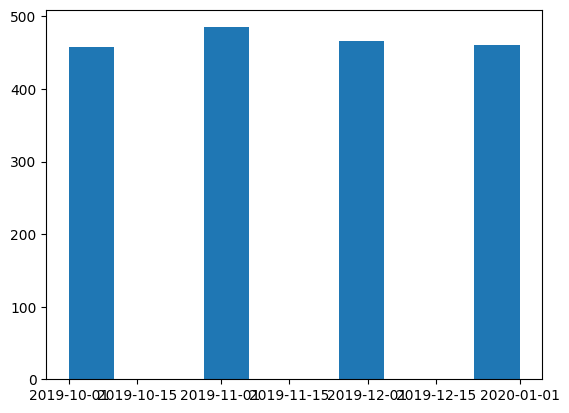

In [8]:
churned['EndDate'] = pd.to_datetime(churned['EndDate'])
plt.hist(churned['EndDate'])

At a glance, there appears to be no apparent trend in the customer end date data.

#### 1.2 Personal

In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
# check for duplicate rows or duplicate customerID's
print(personal.duplicated().sum())
personal['customerID'].value_counts()

0


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

In [11]:
personal.sample(10, random_state=617)

,customerID,gender,SeniorCitizen,Partner,Dependents
5291,1334-PDUKM,Female,0,Yes,No
3575,9501-UKKNL,Male,0,No,No
1472,9283-LZQOH,Male,0,Yes,Yes
1598,7552-KEYGT,Male,0,Yes,No
6786,9820-RMCQV,Female,0,No,No
2258,9150-HEPMB,Male,0,No,No
654,4160-AMJTL,Female,1,No,No
813,3551-GAEGL,Male,0,Yes,Yes
6569,2229-DPMBI,Female,0,Yes,Yes
1794,5377-NDTOU,Female,0,Yes,Yes


In [12]:
for col in personal.columns[1:]:
    print(col, '-', personal[col].unique())

gender - ['Female' 'Male']
SeniorCitizen - [0 1]
Partner - ['Yes' 'No']
Dependents - ['No' 'Yes']


There are no missing values or duplicate rows in this datset. 

Each of the columns beyond `'customerID'` are essentially binary/boolean categories stored as strings and ints. 

The datatypes need to be standardized to help prepare for model training. Alternatively, we can leave the data as-is and address this issue during encoding of the categorical variables.

#### 1.3 Internet data

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
# check for duplicate rows or duplicate customerID's
print(internet.duplicated().sum())
internet['customerID'].value_counts()

0


7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

Immediately, we see that this dataset is smaller than the other two datasets. This is likely because there are customers who have phone service but not internet service, so they would show up in the contract data and the personal data but not the internet data. We will look to confirm this and address any complications that arise.

There are no missing values or duplicate rows present in this dataset.

In [15]:
internet.sample(10, random_state=617)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4899,0885-HMGPY,DSL,Yes,Yes,Yes,Yes,No,No
3208,8687-BAFGU,Fiber optic,No,No,No,Yes,No,No
5069,0488-GSLFR,Fiber optic,No,No,No,No,No,No
2079,2011-TRQYE,DSL,No,Yes,Yes,No,No,No
2949,9351-HXDMR,Fiber optic,Yes,No,Yes,Yes,Yes,Yes
4575,9873-MNDKV,DSL,No,No,No,No,No,No
584,6439-GTPCA,Fiber optic,No,No,Yes,Yes,No,No
1431,5663-QBGIS,Fiber optic,No,Yes,No,No,Yes,Yes
548,7501-IWUNG,DSL,No,No,Yes,Yes,Yes,Yes
3984,9633-DENPU,DSL,No,Yes,No,No,Yes,No


In [16]:
for col in internet.columns[1:]:
    print(col, '-', internet[col].unique())

InternetService - ['DSL' 'Fiber optic']
OnlineSecurity - ['No' 'Yes']
OnlineBackup - ['Yes' 'No']
DeviceProtection - ['No' 'Yes']
TechSupport - ['No' 'Yes']
StreamingTV - ['No' 'Yes']
StreamingMovies - ['No' 'Yes']


Once again, each of the columns beyond `'customerID'` are practically boolean/binary categories stored as strings. 

#### 1.4 Phone data

In [17]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


As with the internet data, this set is smaller than contracts/personal - assumed to be accounted for by customers with internet plans but no phone plans.

In [18]:
# check for duplicate rows or duplicate customerID's
print(phone.duplicated().sum())
phone['customerID'].value_counts()

0


5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

In [19]:
phone.sample(10, random_state=617)

,customerID,MultipleLines
5673,5813-UECBU,Yes
1739,8232-UTFOZ,No
1849,0308-GIQJT,Yes
1432,5014-WUQMG,No
89,0278-YXOOG,No
490,6986-IJDHX,No
5712,5442-BHQNG,No
2413,4391-LNRXK,No
3027,0337-CNPZE,Yes
4060,9541-ZPSEA,No


The phone dataset contains no missing or duplicate values and the only column beyond `'customerID'`, `'MultipleLines'`,  again contains Yes/No string values in place of a more natural boolean cateogorization.

### *Project Plan

Data cleaning:
- Convert column names from CamelCase to snake_case
- Convert column datatypes for `'BeginDate'`, `'TotalCharges'`

Feature engineering & preprocessing:
- Merge all datasets on the customerID column
- Address missing values from internet and phone 
  - Internet: fill `'InternetService'` with `'None'` to preserve lack of internet plan as info, \
fill other columns with `'No'`        
  -  Phone: fill `'MultipleLines'` with `'None'` to preserve lack of phone plan as info
- Add "account_age" column, using `'EndDate'` and known data collection date
- Encode categorical variables
- Split data into training, testing, validation sets

Model training:
- Create a LogisticRegression as a baseline, as this is a classification task (churn or stay)
- Train different models with different hyperparameters to find best model 
- Test final model against test set

Report findings:
- Observe final ROC-AUC scores
- Consider scores in context of business problem
- Examine target group and highlight commonalities and correlations
- Make data-supported suggestions regarding promotional offers

Notes:

- Consider effects of class imbalance (roughly 3:1)

Questions: 
- Only 4 `'EndDate'` dates - are there no earlier cancellations?
- Are there earlier data snapshots to capture changes in services?


### 2. Data Cleaning

#### 2.1 Fixing Column Names

In [20]:
# adjust column names to snake_case
contract.columns = ['customer_id',
                 'begin_date',
                 'end_date',
                 'type',
                 'paperless_billing',
                 'payment_method',
                 'monthly_charges',
                 'total_charges']

personal.columns = ['customer_id',
                    'gender',
                    'senior_citizen',
                    'partner',
                    'dependents']

internet.columns = ['customer_id',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies']

phone.columns = ['customer_id',
                 'multiple_lines']

# view each dataset's column names
for set in [contract, personal, internet, phone]:
    print(set.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


#### 2.2 Fixing Datatypes

In [21]:
# convert begin_date to datetime
contract['begin_date'] = contract['begin_date'].astype('datetime64[D]')


Trying to convert `'total_charges'` to float gives an error, let's push through the errors with `errors='coerce'` and investigate further.


In [22]:
# convert 'total_charges' to float, if it gives an error then it's NaN
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# look at all rows with null total_charges
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


All of the `'total_charges'` values that we forced to NaN are from customers that just joined and likely haven't been billed for their first monthly payment yet. Filling these with 0 is reasonable as they may not have made any payments yet.

In [23]:
# replace np.nan instances with 0
contract['total_charges'].replace(np.nan, 0., inplace=True)

# confirm changes
contract[contract['total_charges'] == 0]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


### 3. Feature Engineering and Preprocessing

#### 3.1 Merge Datasets

In [24]:
# merge dataframes on the 'customer_id' column, using how='left' to preserve all values from contract dataframe
data = contract.merge(personal, 'left', 'customer_id') \
               .merge(internet, 'left', 'customer_id') \
               .merge(phone, 'left', 'customer_id')

print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


We can see the missing values from our merged internet and phone datasets, which were each shorter than contract and personal datasets were. Let's fill these according to our plan.

#### 3.2 Fill in Missing Values

In [25]:
# first fill columns we want to "preserve" with 'None'
data['internet_service']  = data['internet_service'].fillna('None')
data['multiple_lines']  = data['multiple_lines'].fillna('None')

# fill remaining empty values with 'No'
data = data.fillna('No')
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

#### 3.3 Add Features

In [26]:
# create a function to return 0 if customer has not left, 1 if they have
def get_churn(df):
    if df['end_date'] == 'No':
        return 0
    else:
        return 1
    
# apply function to our dataframe to create the column
data['churn'] = data.apply(get_churn, axis=1)

# confirm that the column was added with values as intended
data[['customer_id', 'end_date', 'churn']].sample(10)

,customer_id,end_date,churn
463,3811-VBYBZ,2019-10-01 00:00:00,1
5844,2905-KFQUV,No,0
1702,4423-YLHDV,2019-11-01 00:00:00,1
6291,2890-WFBHU,No,0
696,0078-XZMHT,No,0
1737,8887-IPQNC,No,0
1233,1299-AURJA,No,0
6697,8080-POTJR,No,0
6785,3090-HAWSU,2019-11-01 00:00:00,1
2344,9796-MVYXX,No,0


In [27]:
# use data in 'end_date' to determine account age
def get_age(df):
    if df['end_date'] == 'No':
        end_date = pd.to_datetime('2020-02-01')
    else: 
        end_date = pd.to_datetime(df['end_date'])
    
    age = end_date - df['begin_date']

    return float(age.days)

data['account_age'] = data.apply(get_age, axis=1).astype('float64')

#### 3.4 Encode Features

In [28]:
# collect categorical columns
cat_cols = list(personal.columns[1:]) + list(internet.columns[1:]) + list(phone.columns[1:])
cat_cols.append('type')
cat_cols.append('paperless_billing')
cat_cols.append('payment_method')
cat_cols


['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'type',
 'paperless_billing',
 'payment_method']

In [29]:
# useful data has been extracted from this column, remove it to avoid data leaks
data = data.drop('end_date', axis=1)

In [30]:
# use one hot encoding, dropping the first column of each result to avoid introducing data leaks
data_ohe = pd.get_dummies(data, columns=cat_cols, drop_first=True)
data_ohe

,customer_id,begin_date,monthly_charges,total_charges,churn,account_age,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,...,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_None,multiple_lines_Yes,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,7590-VHVEG,2020-01-01,29.85,29.85,0,31.0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
1,5575-GNVDE,2017-04-01,56.95,1889.50,0,1036.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2019-10-01,53.85,108.15,1,61.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,2016-05-01,42.30,1840.75,0,1371.0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,9237-HQITU,2019-09-01,70.70,151.65,1,61.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,84.80,1990.50,0,730.0,1,0,1,1,...,1,1,0,1,1,0,1,0,0,1
7039,2234-XADUH,2014-02-01,103.20,7362.90,0,2191.0,0,0,1,1,...,1,1,0,1,1,0,1,1,0,0
7040,4801-JZAZL,2019-03-01,29.60,346.45,0,337.0,0,0,1,1,...,0,0,1,0,0,0,1,0,1,0
7041,8361-LTMKD,2019-07-01,74.40,306.60,1,123.0,1,1,1,0,...,0,0,0,1,0,0,1,0,0,1


#### 3.6 Supplemental EDA

In [31]:
px.histogram(data['monthly_charges'], color=data['churn'], barmode='overlay')

In [32]:
px.histogram(data['account_age'], color=data['churn'], barmode='overlay', histnorm='percent')

In [33]:
px.scatter(data, x='begin_date', y='monthly_charges', color='churn')

In [34]:
px.histogram(data, x='monthly_charges', y='type', color='churn', barmode='overlay')

In [35]:
px.histogram(data, x='monthly_charges', color='type', barmode='overlay', histnorm='percent')

### 3.7 Designate Features & Target

In [36]:
# drop 'customer_id' as it is not useful, 'begin_date' to avoid data leaks, and 'churn' as it's our target
features = data_ohe.drop(['customer_id', 'begin_date', 'churn'], axis=1)
target = data_ohe['churn']
features.columns

Index(['monthly_charges', 'total_charges', 'account_age', 'gender_Male',
       'senior_citizen_1', 'partner_Yes', 'dependents_Yes',
       'internet_service_Fiber optic', 'internet_service_None',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'multiple_lines_None', 'multiple_lines_Yes', 'type_One year',
       'type_Two year', 'paperless_billing_Yes',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check'],
      dtype='object')

In [37]:
# look for basic strength of correlation between features and target
features.corrwith(target).sort_values(ascending=False)

internet_service_Fiber optic              0.308020
payment_method_Electronic check           0.301919
monthly_charges                           0.193356
paperless_billing_Yes                     0.191825
senior_citizen_1                          0.150889
streaming_tv_Yes                          0.063228
streaming_movies_Yes                      0.061382
multiple_lines_Yes                        0.040102
gender_Male                              -0.008612
multiple_lines_None                      -0.011942
device_protection_Yes                    -0.066160
online_backup_Yes                        -0.082255
payment_method_Mailed check              -0.091683
payment_method_Credit card (automatic)   -0.134302
partner_Yes                              -0.150448
dependents_Yes                           -0.164221
tech_support_Yes                         -0.164674
online_security_Yes                      -0.171226
type_One year                            -0.177820
total_charges                  

No correlation is explicitly strong in either direction, but we can still gain information from their relative values.

Fiberoptic internet service is highly correlated with churn, relative to other features, as are the monthly charges. Conversely, we see that account age and one/two year plans are correlated with customers continuing service.

This supports what we see in the data visualization EDA above:
- Customers with low monthly payments are likely to continue service, while those with high monthly payments are more likely to churn.

- Newer customers are more likely to churn - over 50% of churned customers ended their service in the first 250 days.

- Customers on a month-to-month type plan are far more likely to churn than those on one- or two-year plan types.

- Customers who have fiberoptic internet plans are far more likely to churn than customers with no internet service at all; this is likely related to the monthly charges.

- Some services like tech support and online security have relatively moderate negative correlations with churn - maybe customers really like these services.

- Interestingly, those who pay by electronic check are more likely to churn than others. It could be the case that this payment method is a pain to use, or carries a fee?

### 4. Model Training

#### 4.1 Preprocessing

In [38]:
# split features and target into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=617)

# check that we got the intended split and that our sets have similar churn rates
print(features_train.shape, target_train.shape, target_train.mean())
print(features_test.shape, target_test.shape, target_test.mean())


(5634, 23) (5634,) 0.26766063187788425
(1409, 23) (1409,) 0.25621007806955287


#### 4.2 Model Training & Hyperparameter Tuning

In [39]:
# define parameter grids for different model types
# these will be ultimately be passed to GridSearchCV

param_grid_lr = {'model__solver': ['liblinear']}

param_grid_rf = {'model__n_estimators': list(range(50, 251, 50)),
                 'model__max_depth': list(range(4, 9)),
                 'model__random_state': [617]
              }

param_grid_cb = {'model__iterations': list(range(50, 251, 50)),
                 'model__depth': list(range(4, 9)),
                 'model__learning_rate': list(np.arange(0.01, 0.11, 0.03)),
                 'model__random_seed': [617],
                 'model__verbose': [False]
              }

param_grid_lgbm = {'model__num_iterations': list(range(50, 251, 50)),
                   'model__learning_rate': list(np.arange(0.01, 0.11, 0.03)),
                   'model__verbose': [-1]
                   }

In [40]:
# create training pipelines to scale, select features,
#    balance classification, and tune hyperparameters for our models
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest()),
    ('oversampler', SMOTE()),
    ('model', LogisticRegression())
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest()),
    ('oversampler', SMOTE()),
    ('model', RandomForestClassifier())
])

pipeline_cb = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest()),
    ('oversampler', SMOTE()),
    ('model', CatBoostClassifier())
])

pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest()),
    ('oversampler', SMOTE()),
    ('model', LGBMClassifier())
])

In [41]:
# create a scorer to use in GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# define a simple function to do perform and return a grid search for a given model
def grid_search(model,
                params,
                train_features=features_train,
                train_target=target_train
                ):
      gs = GridSearchCV(model,
                           param_grid=params,
                           scoring=roc_auc_scorer,
                           cv=3,
                           verbose=3
                           )
      gs = gs.fit(train_features, train_target)
      
      print('Best ROC-AUC score:', gs.best_score_)
      print('Best model F1-Score:', f1_score(train_target, gs.best_estimator_.predict(train_features)))

      return gs

##### 4.2.a Logistic Regression Baseline

In [42]:
# apply the grid_search function to a Logistic Regression model, which prints the best ROC-AUC score in its process
grid_search(pipeline_lr, param_grid_lr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...........model__solver=liblinear;, score=0.842 total time=   0.0s
[CV 2/3] END ...........model__solver=liblinear;, score=0.842 total time=   0.0s
[CV 3/3] END ...........model__solver=liblinear;, score=0.838 total time=   0.0s
Best ROC-AUC score: 0.8403467647562985
Best model F1-Score: 0.6245468669083376


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector', SelectKBest()),
                                       ('oversampler', SMOTE()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__solver': ['liblinear']},
             scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=3)

##### 4.2.b Random Forest Classifier

In [43]:
# apply function to a RandomForestClassifier model
best_rf_model = grid_search(pipeline_rf, param_grid_rf)
print(best_rf_model.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END model__max_depth=4, model__n_estimators=50, model__random_state=617;, score=0.848 total time=   0.1s
[CV 2/3] END model__max_depth=4, model__n_estimators=50, model__random_state=617;, score=0.851 total time=   0.1s
[CV 3/3] END model__max_depth=4, model__n_estimators=50, model__random_state=617;, score=0.845 total time=   0.1s
[CV 1/3] END model__max_depth=4, model__n_estimators=100, model__random_state=617;, score=0.851 total time=   0.3s
[CV 2/3] END model__max_depth=4, model__n_estimators=100, model__random_state=617;, score=0.851 total time=   0.3s
[CV 3/3] END model__max_depth=4, model__n_estimators=100, model__random_state=617;, score=0.843 total time=   0.3s
[CV 1/3] END model__max_depth=4, model__n_estimators=150, model__random_state=617;, score=0.850 total time=   0.5s
[CV 2/3] END model__max_depth=4, model__n_estimators=150, model__random_state=617;, score=0.851 total time=   0.5s
[CV 3/3] END model__ma

##### 4.2.c Gradient Boosting

In [44]:
# apply function to CatBoostClassifier model
best_cb_model = grid_search(pipeline_cb, param_grid_cb)
print(best_cb_model.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__depth=4, model__iterations=50, model__learning_rate=0.01, model__random_seed=617, model__verbose=False;, score=0.850 total time=   0.2s
[CV 2/3] END model__depth=4, model__iterations=50, model__learning_rate=0.01, model__random_seed=617, model__verbose=False;, score=0.839 total time=   0.1s
[CV 3/3] END model__depth=4, model__iterations=50, model__learning_rate=0.01, model__random_seed=617, model__verbose=False;, score=0.836 total time=   0.0s
[CV 1/3] END model__depth=4, model__iterations=50, model__learning_rate=0.04, model__random_seed=617, model__verbose=False;, score=0.856 total time=   0.0s
[CV 2/3] END model__depth=4, model__iterations=50, model__learning_rate=0.04, model__random_seed=617, model__verbose=False;, score=0.851 total time=   0.0s
[CV 3/3] END model__depth=4, model__iterations=50, model__learning_rate=0.04, model__random_seed=617, model__verbose=False;, score=0.843 total time=   0.0s
[

In [45]:
# apply function to LGBMClassifier model
best_lgbm_model = grid_search(pipeline_lgbm, param_grid_lgbm)
print(best_lgbm_model.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END model__learning_rate=0.01, model__num_iterations=50, model__verbose=-1;, score=0.864 total time=   0.0s
[CV 2/3] END model__learning_rate=0.01, model__num_iterations=50, model__verbose=-1;, score=0.867 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.01, model__num_iterations=50, model__verbose=-1;, score=0.844 total time=   0.0s
[CV 1/3] END model__learning_rate=0.01, model__num_iterations=100, model__verbose=-1;, score=0.864 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.01, model__num_iterations=100, model__verbose=-1;, score=0.870 total time=   0.1s
[CV 3/3] END model__learning_rate=0.01, model__num_iterations=100, model__verbose=-1;, score=0.852 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.01, model__num_iterations=150, model__verbose=-1;, score=0.864 total time=   0.1s
[CV 2/3] END model__learning_rate=0.01, model__num_iterations=150, model__verbose=-1;, score=0.869 total time=   0.1s

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument




[CV 3/3] END model__learning_rate=0.01, model__num_iterations=150, model__verbose=-1;, score=0.855 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.01, model__num_iterations=200, model__verbose=-1;, score=0.877 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.01, model__num_iterations=200, model__verbose=-1;, score=0.873 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.01, model__num_iterations=200, model__verbose=-1;, score=0.861 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.01, model__num_iterations=250, model__verbose=-1;, score=0.872 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.01, model__num_iterations=250, model__verbose=-1;, score=0.881 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.01, model__num_iterations=250, model__verbose=-1;, score=0.858 total time=   0.2s
[CV 1/3] END model__learning_rate=0.04, model__num_iterations=50, model__verbose=-1;, score=0.875 total time=   0.0s
[CV 2/3] END model__learning_rate=0.04, model__num_iterations=50, model__verbose=-1;, score=0.874 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.04, model__num_iterations=50, model__verbose=-1;, score=0.858 total time=   0.0s
[CV 1/3] END model__learning_rate=0.04, model__num_iterations=100, model__verbose=-1;, score=0.890 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.04, model__num_iterations=100, model__verbose=-1;, score=0.886 total time=   0.0s
[CV 3/3] END model__learning_rate=0.04, model__num_iterations=100, model__verbose=-1;, score=0.868 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.04, model__num_iterations=150, model__verbose=-1;, score=0.891 total time=   0.1s
[CV 2/3] END model__learning_rate=0.04, model__num_iterations=150, model__verbose=-1;, score=0.899 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.04, model__num_iterations=150, model__verbose=-1;, score=0.887 total time=   0.1s
[CV 1/3] END model__learning_rate=0.04, model__num_iterations=200, model__verbose=-1;, score=0.893 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.04, model__num_iterations=200, model__verbose=-1;, score=0.902 total time=   0.1s
[CV 3/3] END model__learning_rate=0.04, model__num_iterations=200, model__verbose=-1;, score=0.895 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.04, model__num_iterations=250, model__verbose=-1;, score=0.907 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.04, model__num_iterations=250, model__verbose=-1;, score=0.904 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.04, model__num_iterations=250, model__verbose=-1;, score=0.896 total time=   0.2s
[CV 1/3] END model__learning_rate=0.06999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.882 total time=   0.0s
[CV 2/3] END model__learning_rate=0.06999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.886 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.06999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.868 total time=   0.0s
[CV 1/3] END model__learning_rate=0.06999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.890 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.06999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.905 total time=   0.0s
[CV 3/3] END model__learning_rate=0.06999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.896 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.06999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.905 total time=   0.1s
[CV 2/3] END model__learning_rate=0.06999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.907 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.06999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.895 total time=   0.1s
[CV 1/3] END model__learning_rate=0.06999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.914 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.06999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.916 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.06999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.900 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.06999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.914 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.06999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.917 total time=   0.4s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.06999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.905 total time=   0.2s
[CV 1/3] END model__learning_rate=0.09999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.887 total time=   0.0s
[CV 2/3] END model__learning_rate=0.09999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.889 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.09999999999999999, model__num_iterations=50, model__verbose=-1;, score=0.878 total time=   0.1s
[CV 1/3] END model__learning_rate=0.09999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.901 total time=   0.0s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.09999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.911 total time=   0.0s
[CV 3/3] END model__learning_rate=0.09999999999999999, model__num_iterations=100, model__verbose=-1;, score=0.895 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.09999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.906 total time=   0.1s
[CV 2/3] END model__learning_rate=0.09999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.909 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.09999999999999999, model__num_iterations=150, model__verbose=-1;, score=0.905 total time=   0.1s
[CV 1/3] END model__learning_rate=0.09999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.915 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.09999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.915 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.09999999999999999, model__num_iterations=200, model__verbose=-1;, score=0.897 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 1/3] END model__learning_rate=0.09999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.915 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 2/3] END model__learning_rate=0.09999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.922 total time=   0.2s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[CV 3/3] END model__learning_rate=0.09999999999999999, model__num_iterations=250, model__verbose=-1;, score=0.903 total time=   0.1s


C:\Users\joshg\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best ROC-AUC score: 0.9134770452094617
Best model F1-Score: 0.901222332342253
{'model__learning_rate': 0.09999999999999999, 'model__num_iterations': 250, 'model__verbose': -1}


The grid searches performed on our models showed a positive correlation between depth, iterations, and learning rate. Our boosted models performed best on the target metric.

For scoring, in addition to the primary metric of ROC-AUC score, I've chosen to monitor the F1-score as opposed to the accuracy score, as it is a better metric to use for binary classification tasks. Accuracy does not account for True or False Positives vs. Negatives, only the rate of correct predictions.

Both the CatBoost and LGBM classifiers achieve ROC-AUC above 0.90 during grid search, with the LGBM classifier performing slightly better on ROC-AUC and much better on F-Score.

We will proceed with the "best" LGBM model as our chosen model.

#### 4.3 Final Model Testing

Final Model ROC-AUC: 0.9317840603920408
Final Model F1-score: 0.7771587743732592


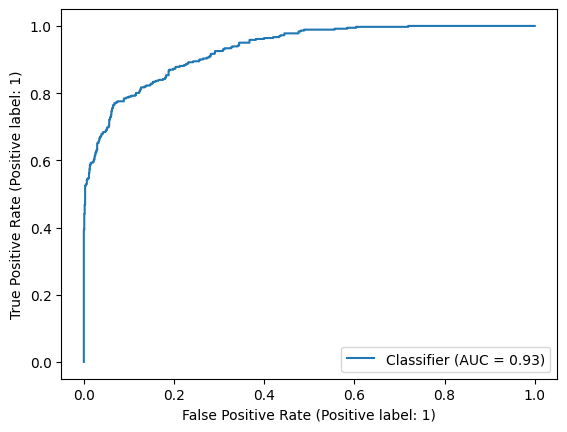

In [46]:
# use final model to make predictions against the test set
test_predictions = best_lgbm_model.predict(features_test)
proba_test = best_lgbm_model.predict_proba(features_test)[:,1]
print('Final Model ROC-AUC:', roc_auc_score(target_test, proba_test))
print('Final Model F1-score:', f1_score(target_test, test_predictions))
print(RocCurveDisplay.from_predictions(target_test, proba_test))


Our final model performed even better against the test set than it did during validation, achieving a ROC-AUC score of 0.93 with an F1-Score of 0.77.

### 5. Conclusions

#### 5.1 Model Analysis


I was able to follow my project plan; it was helpful and successfully guided me to a quality model. It was valuable to plan things out explicitly before beginning.

I faced challenges with making decisions about features to add and remove, and how to handle potential data leaks with customer begin/end dates while preserving the valuable information. I am happy with my decision to remove the dates after calculating customer account age as an additional feature.

I had difficulty with my models overfitting during grid search, but my project leader pointed out the likely effect that upsampled data was having on my cross validation folds. This was resolved by the implementation of a pipeline process to resample the data for each fold.

By carefully handling my data, identifying trends with EDA, and following good practices with splitting, sampling, and model training, I was able to create a model of high enough quality to exceed the goal of a target metric above 0.88 against a test set.

The LGBM Classifier performed the best in this analysis, slightly outperforming the CatBoost Classifier. It is not surprising that these boosted models outperformed the Logistic Regression and Random Forest models.

The boosted models' quality might be improved with more iterations or higher depth, as evidenced by the highest settings we tried for these parameters were giving the best scores.

Ultmately, the final LGBM Classifier model scored a 0.93 ROC-AUC.

#### 5.2 Business Analysis

Our analysis shows that the features that most directly correlate with churn are the age of the customer's account and the subscription to fiber optic internet, which is correlated with the monthly charges. Similarly, customers who are on a month-to-month contract type are more likely to churn than those with one- or two-year contracts.

It seems that once customers stay on past 250 days, they are much less likely to churn. Among newer customers, the ones with the highest payments are likely to churn.

This points to a few possible options to reduce customer churn:

- Introductory pricing: Give customer's a discounted rate for the first year. The goal is to trade off a bit of revenue up front in the hopes that the customer stays on for years.

- Incentivize one/two-year contracts: Customers might be less likely to churn if they sign up for one/two year contracts as this naturally extends their service past the period of highest churn. We could look at including additional services like tech support and online security with one/two-year contracts - services which customers seem to like as they are negatively correlated with churn.